In [1]:
from models.fusion_model import FusionModel
import torch

fusion = FusionModel().cuda()

video_emb  = torch.randn(4, 1024).cuda()
image_emb  = torch.randn(4, 1024).cuda()
audio_emb  = torch.randn(4, 768).cuda()

out = fusion(video_emb, image_emb, audio_emb)
print(out.shape)   # (4, 2)

torch.Size([4, 2])


In [2]:
def collate_batch(batch):
    videos, images, audios, labels = zip(*batch)

    videos = torch.stack(videos)
    images = torch.stack(images)
    audios = torch.stack(audios)
    labels = torch.tensor(labels, dtype=torch.long)

    return videos, images, audios, labels

In [3]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for videos, images, audios, labels in tqdm(loader, desc="Training"):
        videos = videos.to(device)
        images = images.to(device)
        audios = audios.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(videos, images, audios)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total

    return epoch_loss, epoch_acc


In [4]:
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for videos, images, audios, labels in tqdm(loader, desc="Validation"):
            videos = videos.to(device)
            images = images.to(device)
            audios = audios.to(device)
            labels = labels.to(device)

            logits = model(videos, images, audios)
            loss = criterion(logits, labels)

            running_loss += loss.item() * labels.size(0)

            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total

    return epoch_loss, epoch_acc


In [5]:
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

model = FusionModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc     = eval_one_epoch(model, val_loader, criterion, device)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")


NameError: name 'train_dataset' is not defined

In [6]:
#  FULL TEST WITH SAMPLE DATA

In [7]:
import torch
from torch.utils.data import Dataset

class FakeMultimodalDataset(Dataset):
    def __init__(self, n_samples=2000):
        self.n_samples = n_samples

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        video_emb = torch.randn(1024)
        image_emb = torch.randn(1024)
        audio_emb = torch.randn(768)
        label = torch.randint(0, 2, (1,)).item()
        return video_emb, image_emb, audio_emb, label


In [8]:
def collate_batch(batch):
    videos, images, audios, labels = zip(*batch)

    videos = torch.stack(videos)
    images = torch.stack(images)
    audios = torch.stack(audios)
    labels = torch.tensor(labels)

    return videos, images, audios, labels


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class FusionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.video_proj = nn.Linear(1024, 512)
        self.image_proj = nn.Linear(1024, 512)
        self.audio_proj = nn.Linear(768,  512)

        self.fusion = nn.Sequential(
            nn.Linear(512 * 3, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 2)
        )

    def forward(self, v, i, a):
        v = F.relu(self.video_proj(v))
        i = F.relu(self.image_proj(i))
        a = F.relu(self.audio_proj(a))

        fused = torch.cat([v, i, a], dim=-1)
        out = self.fusion(fused)
        return out


In [10]:
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for videos, images, audios, labels in tqdm(loader, desc="Training"):
        videos, images, audios = videos.to(device), images.to(device), audios.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(videos, images, audios)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for videos, images, audios, labels in tqdm(loader, desc="Validation"):
            videos, images, audios = videos.to(device), images.to(device), audios.to(device)
            labels = labels.to(device)

            logits = model(videos, images, audios)
            loss = criterion(logits, labels)

            running_loss += loss.item() * labels.size(0)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


In [11]:
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

# Fake datasets
train_dataset = FakeMultimodalDataset(n_samples=1000)
val_dataset   = FakeMultimodalDataset(n_samples=200)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

# Model
model = FusionModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc     = eval_one_epoch(model, val_loader, criterion, device)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")


Validation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 109.10it/s]



Epoch 1/5
Train Loss: 0.6990 | Train Acc: 0.4770
Val   Loss: 0.6948 | Val   Acc: 0.5050


Validation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 141.22it/s]



Epoch 2/5
Train Loss: 0.7018 | Train Acc: 0.4710
Val   Loss: 0.6970 | Val   Acc: 0.5100


Validation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 161.39it/s]



Epoch 3/5
Train Loss: 0.6941 | Train Acc: 0.5150
Val   Loss: 0.7098 | Val   Acc: 0.4750


Validation: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 96.06it/s]



Epoch 4/5
Train Loss: 0.7015 | Train Acc: 0.4760
Val   Loss: 0.6879 | Val   Acc: 0.5650


Validation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 143.04it/s]


Epoch 5/5
Train Loss: 0.7005 | Train Acc: 0.4920
Val   Loss: 0.6905 | Val   Acc: 0.5300


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
class EmbeddingDataset(Dataset):
    def __init__(self, img_path, vid_path, aud_path):
        img = torch.load(img_path)
        vid = torch.load(vid_path)
        aud = torch.load(aud_path)

        self.img_emb = img["embeddings"]
        self.vid_emb = vid["embeddings"]
        self.aud_emb = aud["embeddings"]
        # self.labels = img["labels"]   # same labels as video

        assert len(self.img_emb) == len(self.vid_emb)
        # print(len(self.img_emb), len(self.vid_emb), len(self.aud_emb))
        
    # def __len__(self):
    #     return len(self.labels)

    def __getitem__(self, idx):
        return (
            self.img_emb[idx],       # (6529)
            self.vid_emb[idx],       # (6529)
            self.aud_emb[idx],       # (53868)
            # self.labels[idx]         # scalar
        )


In [5]:
img_path = "embeddings/image_embeddings.pt"
vid_path = "embeddings/video_embeddings.pt"
aud_path = "embeddings/audio_embeddings.pt"
img = torch.load(img_path)
vid = torch.load(vid_path)
aud = torch.load(aud_path)

aud_projection = nn.Linear(768, 512)
aud_512 = aud_projection(aud["embeddings"])

B, D = aud_512.shape
k = B // 6529
B_new = 6529 * k
aud_trim = aud_512[:B_new]

aud_reshaped = aud_trim.view(6529, k, 512)   # [6529, k, 512]
aud_pooled = {}
aud_pooled["embeddings"] = aud_reshaped.mean(dim=1)       # [6529, 512]   temporal pooling

In [9]:
test_aud_path = "embeddings/test_audio_embeddings.pt"
test_aud = torch.load(test_aud_path)
test_aud["embeddings"]

[tensor([[-0.0389, -0.0108,  0.1508,  ...,  0.1435,  0.5484, -0.2465],
         [ 0.0654, -0.0764,  0.1815,  ..., -0.0281,  0.3928, -0.2203],
         [ 0.2336,  0.2704,  0.0775,  ...,  0.1956,  0.5542,  0.1541],
         ...,
         [ 0.0047, -0.0992,  0.1842,  ...,  0.1839,  0.5232, -0.1744],
         [-0.0082, -0.0588,  0.1546,  ...,  0.1902,  0.5351, -0.2184],
         [ 0.0325, -0.0864,  0.2690,  ...,  0.0300,  0.3622, -0.1464]]),
 tensor([[-0.0030, -0.0055,  0.2207,  ...,  0.1580,  0.5214, -0.1068],
         [ 0.0325,  0.1173, -0.1574,  ..., -0.0370,  0.6767, -0.1627],
         [ 0.0498, -0.0405,  0.2939,  ...,  0.0846,  0.4155, -0.0652],
         ...,
         [ 0.0111,  0.0110,  0.1184,  ...,  0.0842,  0.5005, -0.1435],
         [ 0.0522,  0.0615,  0.1126,  ...,  0.1726,  0.4397, -0.1159],
         [ 0.1249, -0.0386,  0.2160,  ...,  0.1060,  0.3529, -0.1723]]),
 tensor([[ 0.0502,  0.3023, -0.1256,  ...,  0.1725,  0.4815,  0.2226],
         [-0.0019,  0.0417,  0.0990,  ...,  0

In [84]:
import torch
from torch.utils.data import Dataset, DataLoader

class EmbeddingDataset(Dataset):
    def __init__(self, img, vid, aud):
        self.img_emb = img["embeddings"]
        self.vid_emb = vid["embeddings"]
        self.aud_emb = aud["embeddings"]
        self.labels = img["labels"]   # same labels as video

        assert len(self.img_emb) == len(self.vid_emb)
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            self.img_emb[idx],       # torch.Size([6529, 512])
            self.vid_emb[idx],       # torch.Size([6529, 512])
            self.aud_emb[idx],       # torch.Size([53868, 768]) -> [6529, 512]
            self.labels[idx]         # scalar
        )

In [85]:
dataset = EmbeddingDataset(img, vid, aud_pooled)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
dataset.img_emb.shape, dataset.vid_emb.shape, dataset.aud_emb.shape
# for img_emb, vid_emb, aud_emb in loader:
#     print("img embeddings: ", img_emb.shape)
#     print("vid embeddings: ", vid_emb.shape)
#     print("aud embeddings: ", aud_emb.shape)

(torch.Size([6529, 512]), torch.Size([6529, 512]), torch.Size([6529, 512]))

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusionClassifier(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()

        fusion_dim = embed_dim * 3   # img_emb + vid_emb = 1024

        self.fc1 = nn.Linear(fusion_dim, 512)
        self.ln1 = nn.LayerNorm(512)

        self.fc2 = nn.Linear(512, 256)
        self.ln2 = nn.LayerNorm(256)

        self.dropout = nn.Dropout(0.3)

        self.fc_out = nn.Linear(256, 2)  # For CrossEntropy (real/fake)

    def forward(self, img_emb, vid_emb, aud_emb):
        x = torch.cat([img_emb, vid_emb, aud_emb], dim=1)
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.ln2(self.fc2(x)))
        return self.fc_out(x)

In [1]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = FusionClassifier(embed_dim=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

EPOCHS = 1000

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for img_emb, vid_emb, aud_emb, labels in loader:
        
        img_emb = img_emb.detach().to(device)
        vid_emb = vid_emb.detach().to(device)
        aud_emb = aud_emb.detach().to(device)
        
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(img_emb, vid_emb, aud_emb)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss={total_loss:.4f} | Acc={acc:.4f}")


In [94]:
torch.save(model.state_dict(), "ml_model/fusion_model.pth")

In [95]:
model = FusionClassifier(embed_dim=512)
model.load_state_dict(torch.load("ml_model/fusion_model.pth"))
model.eval()

FusionClassifier(
  (fc1): Linear(in_features=1536, out_features=512, bias=True)
  (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=256, out_features=2, bias=True)
)

In [96]:
device = next(model.parameters()).device

img_emb = img_emb.to(device)
vid_emb = vid_emb.to(device)

model.eval()
with torch.no_grad():
    preds = model(img_emb, vid_emb).argmax(dim=1)

TypeError: FusionClassifier.forward() missing 1 required positional argument: 'aud_emb'

In [16]:
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate(model, dataloader, device="cuda"):
    model.eval()
    
    all_preds = []
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for img_emb, vid_emb, labels in dataloader:

            img_emb = img_emb.to(device)
            vid_emb = vid_emb.to(device)
            labels = labels.to(device)

            logits = model(img_emb, vid_emb)
            probs = F.softmax(logits, dim=1)[:, 1]  # probability of FAKE class
            preds = logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_scores.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # ----- METRICS -----
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(all_labels, all_preds)

    # -------- PRINT RESULTS --------
    print("\n📊 Evaluation Results")
    print(f"Accuracy        : {acc:.4f}")
    print(f"Precision       : {prec:.4f}")
    print(f"Recall          : {rec:.4f}")
    print(f"F1-score        : {f1:.4f}")
    print(f"ROC-AUC         : {roc_auc:.4f}")

    # -------- PLOTS --------
    # ROC Curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Real", "Fake"],
                yticklabels=["Real", "Fake"])
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm
    }


In [18]:
class FusionEmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, img_emb, vid_emb, labels):
        self.img = img_emb
        self.vid = vid_emb
        self.lbl = labels

    def __len__(self):
        return len(self.lbl)

    def __getitem__(self, idx):
        return self.img[idx], self.vid[idx], self.lbl[idx]


In [19]:
test_dataset = FusionEmbeddingDataset(img_emb, vid_emb, labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

C:\Users\muthu\miniconda3\envs\multi_env\Lib\site-packages\sklearn\metrics\_ranking.py:1192: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
C:\Users\muthu\miniconda3\envs\multi_env\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



📊 Evaluation Results
Accuracy        : 1.0000
Precision       : 1.0000
Recall          : 1.0000
F1-score        : 1.0000
ROC-AUC         : nan


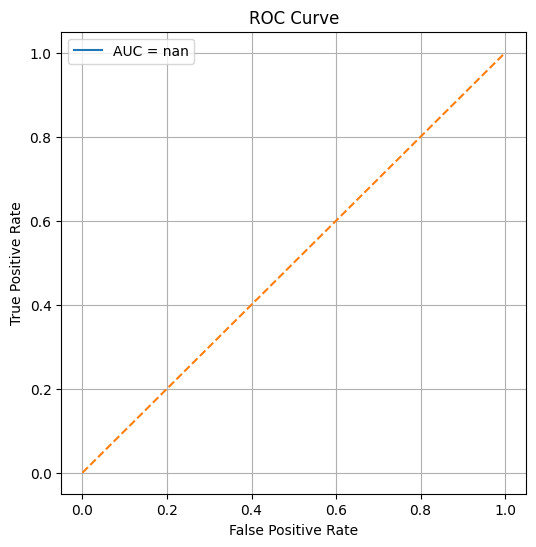

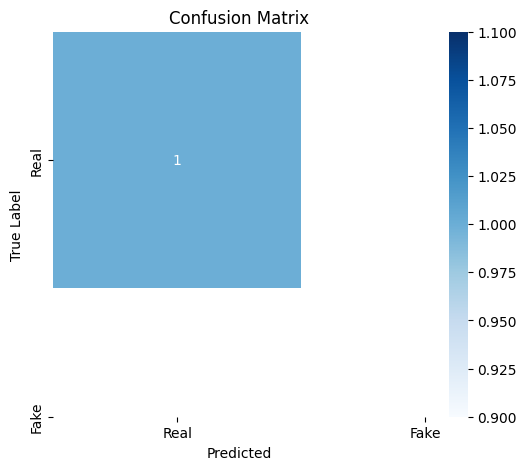

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FusionClassifier().to(device)
model.load_state_dict(torch.load("ml_model/fusion_model.pth"))

results = evaluate(model, test_loader, device)